## Setting things up
add a shortcut to this following folder into your own google drive, so you don't need your local harddrive storage:

https://drive.google.com/drive/folders/10zzTzXgi9CvCEZNw6fG9fsIVjUXNijUu?usp=sharing

The first few lines of this code will mount your drive and read the data via the shortcut. You may need to authorize Colab to read your Drive, just follow the code's output instructions.

**Note** this folder is different from the last exercise folder. We've used the code from the last exercise and generated sliced windows with labels of the orginial dataset.


## Classifying activities with the PAMAP dataset we introduced in exercise 1, and use deep learning models

Previously in ex2, we used k-fold cross validation with a single participant's data and some simple features, with KNN or svm classifiers to detect the activities. In this exercise, we will reuse some of the codes from ex2, like loading the original data and balancing the samples. But we will do something different:


1.   First we will do leave-person-out validation instead of k-fold within a single person
2.   Intead of calculating features, we will use a deep neural network that feeds directly on the sensor data. Remember in the previous ex2 we need to first calculate abstract features for every sample window before giving the data to the classifier, because probabilisitc classifiers do not directly work on raw multichannel temporal data.
3.   Because training a neural network is different from fitting a classifier, as classifiers are mathematical representations and the current implementations give you the optimal result. Training a neural network 



For this exercise, you may have to refer to the tensorflow documentation. But we have placed as many comments as possible to guide you.
https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [ ]:
#import the packages that we need
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import itertools
from sklearn import neighbors, metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Import files from drive
from google.colab import drive
drive.mount('/content/drive')
# this might prompt you to authorize and might take a minute
!cp -r "/content/drive/My Drive/PAMAP2_Dataset/WindowSamples" .

Mounted at /content/drive


In [ ]:
def loadXy(ID):
  # Default file names
  fileName = 'WindowSamples/subject10'+str(ID)+'.npz'
  # Load data from numpy file
  data = np.load(fileName)
  # first lets see what's in the file
  #for k in data.iterkeys():
  #  print(k)
  # Skip the first column because it's timestamp
  X = data['arr_0'][:,:,1:4] 
  y = data['arr_1']
  return X, y

def balance_data(X, y):
  X_balanced = np.zeros((0, X.shape[1], X.shape[2])) #note we've changed from X_features to X for simplicity
  y_balanced = np.zeros((0)) 
  #first let's count how many samples are in each class.
  numClass = len(np.unique(y))
  m_counts = np.zeros((numClass))
  m_labels = np.unique(y)
  for i in range(0, numClass):
    m_counts[i] = int(sum(y==m_labels[i]))
  m_least = int(m_counts.min())
  for i in range(1, numClass): # note we are jumping over class 0 now
    rand_ind = np.random.permutation(int(m_counts[i]))
    m_subind = np.where(y==m_labels[i]) # this is the sub-index of the current class in the whole data file
    m_subind_balanced = m_subind[0][rand_ind[0:m_least]]
    # add the selected samples from the current class to the overall balanced dataset
    X_balanced = np.concatenate( (X_balanced, X[m_subind_balanced,:,:]) )
    y_balanced = np.concatenate( (y_balanced, y[m_subind_balanced]) )
  return X_balanced, y_balanced

def plot_confusion_matrix(cm, class_names):
  """
  You can mostly ignore this function
  Returns a matplotlib figure containing the plotted confusion matrix.
  Args:
  cm (array, shape = [n, n]): a confusion matrix of integer classes
  class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(len(class_names)/2, len(class_names)/2))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  acc = np.sum( cm * np.eye(len(class_names)) ) / np.sum(cm)

  plt.title("CM , acc:"+str(round(acc,4)))
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  #plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.show()
  return figure

def label2categorical(m_labels, numClass):
  m_labels_exp = np.zeros( ( len(m_labels), numClass ) )
  LUT = np.unique(m_labels) # to handel sporadically distributed labels
  for i in range (0, len(m_labels)):
      m_labels_exp[i, np.where(LUT==int(m_labels[i]))] = 1
  return m_labels_exp

In [ ]:
X, y = loadXy(1)
X_test, y_test = balance_data(X, y)

print(X_test.shape)
print(y_test.shape)

# Check the activites performed by the subject
print(np.unique(y_test))
numClass = len(np.unique(y_test))

(3048, 200, 3)
(3048,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
# then we prepare the training data with persons 2-8
X_train = np.zeros((0,200,3)) # (sample, time, channel)
y_train = np.zeros((0))
for ID in range(2,8):
  print('ID: '+str(ID))
  X, y = loadXy(ID)
  X, y = balance_data(X,y)
  X_train = np.concatenate( (X_train, X) )
  y_train = np.concatenate( (y_train, y) )

print(X_train.shape)
print(y_train.shape)

# Check the activites performed by the subjects
print(np.unique(y_train))
numClass = len(np.unique(y_train))

ID: 2
ID: 3
ID: 4
ID: 5
ID: 6
ID: 7
(9093, 200, 3)
(9093,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
def build_CNN(filters = 20, kernel = (3), dense = 20, numClass = 12):
  model = keras.models.Sequential([
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu', input_shape=(200,3)),
        layers.MaxPooling1D(pool_size=(5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=(5)),
        layers.Dropout(0.2),
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(dense, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(numClass, activation='softmax')
  ])
  return model



In [ ]:
model = build_CNN()
# optimizer
m_opt = keras.optimizers.Adam()
model.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 20)           200       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 20)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 20)            80        
_________________________________________________________________
dropout (Dropout)            (None, 40, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 20)            1220      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 20)            80        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 20)             0

In [ ]:
# open loop training code block
epoch = 100
batch = 200
numClass = 12
history = model.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
              verbose = 2
        )


Epoch 1/100
46/46 - 4s - loss: 0.6143 - accuracy: 0.1408
Epoch 2/100
46/46 - 2s - loss: 0.3619 - accuracy: 0.2447
Epoch 3/100
46/46 - 2s - loss: 0.2757 - accuracy: 0.3294
Epoch 4/100
46/46 - 2s - loss: 0.2437 - accuracy: 0.4011
Epoch 5/100
46/46 - 2s - loss: 0.2217 - accuracy: 0.4703
Epoch 6/100
46/46 - 2s - loss: 0.2023 - accuracy: 0.5257
Epoch 7/100
46/46 - 2s - loss: 0.1876 - accuracy: 0.5688
Epoch 8/100
46/46 - 2s - loss: 0.1768 - accuracy: 0.6033
Epoch 9/100
46/46 - 2s - loss: 0.1668 - accuracy: 0.6259
Epoch 10/100
46/46 - 2s - loss: 0.1604 - accuracy: 0.6448
Epoch 11/100
46/46 - 2s - loss: 0.1523 - accuracy: 0.6606
Epoch 12/100
46/46 - 2s - loss: 0.1474 - accuracy: 0.6781
Epoch 13/100
46/46 - 2s - loss: 0.1407 - accuracy: 0.6990
Epoch 14/100
46/46 - 2s - loss: 0.1366 - accuracy: 0.7082
Epoch 15/100
46/46 - 2s - loss: 0.1326 - accuracy: 0.7170
Epoch 16/100
46/46 - 2s - loss: 0.1284 - accuracy: 0.7259
Epoch 17/100
46/46 - 2s - loss: 0.1255 - accuracy: 0.7364
Epoch 18/100
46/46 - 2s

dict_keys(['loss', 'accuracy'])


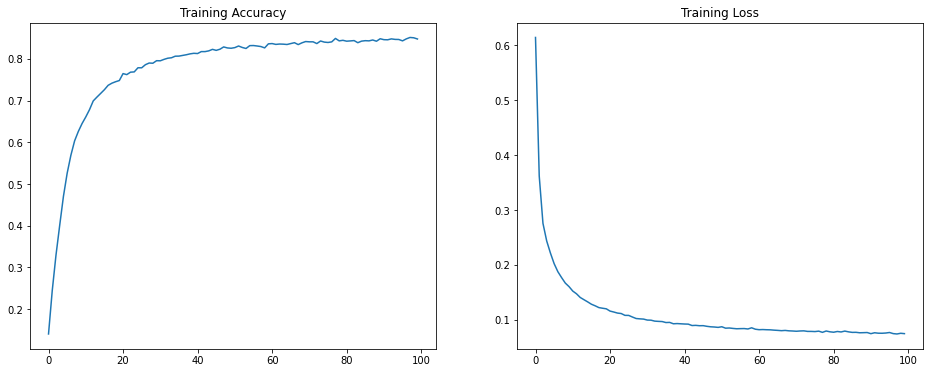

In [ ]:
# history contains the training information about accuracy and loss in every epoch
print(history.history.keys())

figure = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.show()

[[148   3   3   0   0   0   0   0   0  39  60   1]
 [120  55  67   0   0   0   0   0   0   1  11   0]
 [ 50  18 153   0   0   0   0   0   0   0  33   0]
 [  0   3   0 230   0   0   0   7   1   0  13   0]
 [  0   2   0   0 239   0   0   2   0   0  11   0]
 [  0   1   0   0   0 242   0   0   0   0  11   0]
 [  0   4   0   0  10   0 207   0   5   6  22   0]
 [  5   5   2  15   0   0   0 203   0   0  24   0]
 [  3  12   2   2   0   0   0  86 128   0  21   0]
 [  0   0   3   0   0  37   0   0   0 196  18   0]
 [  2   9   0   0   0  19   0   0   1   3 220   0]
 [  0   0   0   0  31   0   1   0 129   7  27  59]]


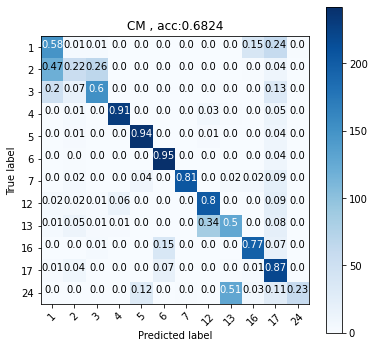

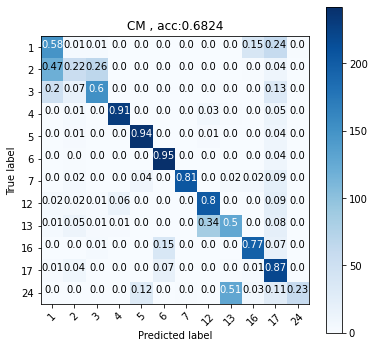

In [ ]:
y_predict = model.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
# Convert back from categorical to numerical with np.argmax()
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1)) 
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))

We can train the model for more epochs, just re-run the open loop training code block. Because the model is kept after model.fit(). You can compare the confusion matrix after more training epochs. Note this is not expected to be highly accurate because we are doing leave-person-out, so the model is being tested on a complete stranger to generate the confusion matrix.

But, we have no means of knowing when to stop training. So in deep learning there is a 'validation' process that can be included in the model.fit(). You SHOULD not use the testing data for validation, as that will be overfitting the training process for the testing data. We have person 1 as test, person 2-8 as training. We can use a random split among the training data to separate training and validation data.
Then we can stop the training process when we think the validation has reached a stable plateau number.
Be sure that training, validation and testing should not overlap.

In [ ]:
X_fit = X_train
y_fit = y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, shuffle = True)

print(y_train.shape)
print(y_valid.shape)
# make sure no classes are left out in the validation data
print(np.unique(y_train))
print(np.unique(y_valid))

(6627,)
(737,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
# closed loop training with validation data and early stopping
#first lest build a clean sheet model
model = build_CNN()
# optimizer
m_opt = keras.optimizers.Adam()
model.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model.summary()

epoch = 5000 # we can afford to have more epochs, because the process will be stoped by the early stopping mechanism
batch = 200
patience = 100 # we wait for 100 epochs after the monitor value does not improve and then stop the process
modelfile = 'model.h5'
cb_checkpoint = keras.callbacks.ModelCheckpoint(modelfile, monitor='val_accuracy', mode='max', 
                                                    verbose=1, save_weights_only=True, save_best_only=True)
cb_earlystop = keras.callbacks.EarlyStopping(patience=patience, monitor='val_accuracy', verbose = 1, restore_best_weights=True )
history = model.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
          #use_multiprocessing = True,
          validation_data = (X_valid, label2categorical(y_valid, numClass)),
          callbacks=[cb_checkpoint, cb_earlystop],
          verbose = 2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 200, 20)           200       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 40, 20)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 20)            80        
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 20)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 40, 20)            1220      
_________________________________________________________________
batch_normalization_7 (Batch (None, 40, 20)            80        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8, 20)            

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


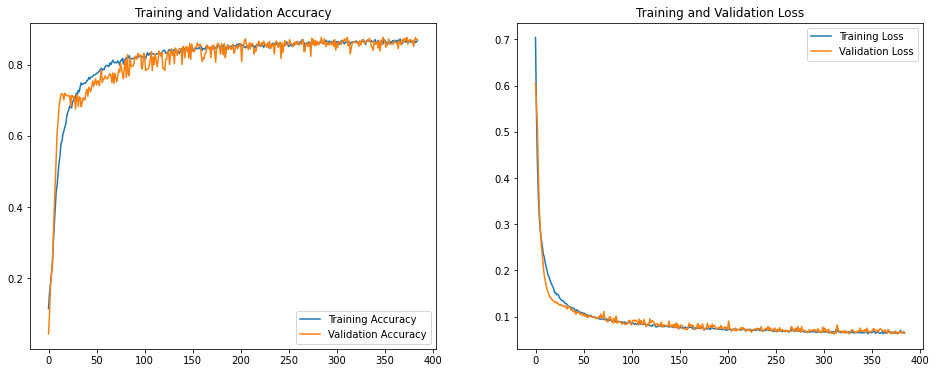

[[114 116   3   0   0   0   0   0   0   1  20   0]
 [ 48 116  55   1   0   0   0   0   0   2  32   0]
 [  6  34 183   0   0   0   0   0   0   2  29   0]
 [  0   2   0 222   0   0   1   8   4   0  17   0]
 [  0   1   0   0 239   0   0   1   2   0  11   0]
 [  0   0   0   0   0 240   0   0   0   0  14   0]
 [  0   0   0   0  20   0 197   0   4   7  26   0]
 [  0   6   6  43   0   0   0 177   3   0  19   0]
 [  0  10   4   7   0   0   0  50 158   0  25   0]
 [  0   0   2   0   0   5   1   0   0 228  18   0]
 [  0   6   0   0   0   9   0   0   2   7 230   0]
 [  0   0   0   0  31   0   3   0  50  19  25 126]]


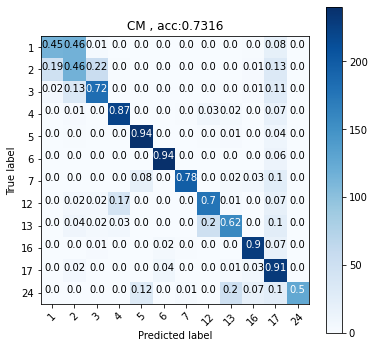

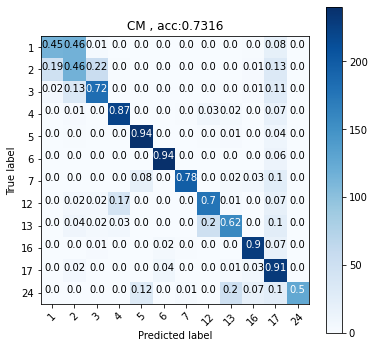

In [ ]:
print(history.history.keys())
figure = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_predict = model.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1))
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))


# Epilogue

In this exercise we've seen how to classify activities from multi-channel temporal sensor data with (not so) deep neural networks.

The confusion matrix is not directly comparable with ex2, because in ex2 we did cross-validation with only one person's data, but here we have proper leave-person-out.

You can try modify the model structure, play around with the dimensions, or LSTM layers, and see if you can have different results.
You can see how different layers work in this documentation:
https://www.tensorflow.org/api_docs/python/tf/keras/layers
But it is only for your own interest, not in the scope of the exam.